In [247]:
import background as bg
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import colorsys
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
plt.rcParams['figure.dpi'] = 150

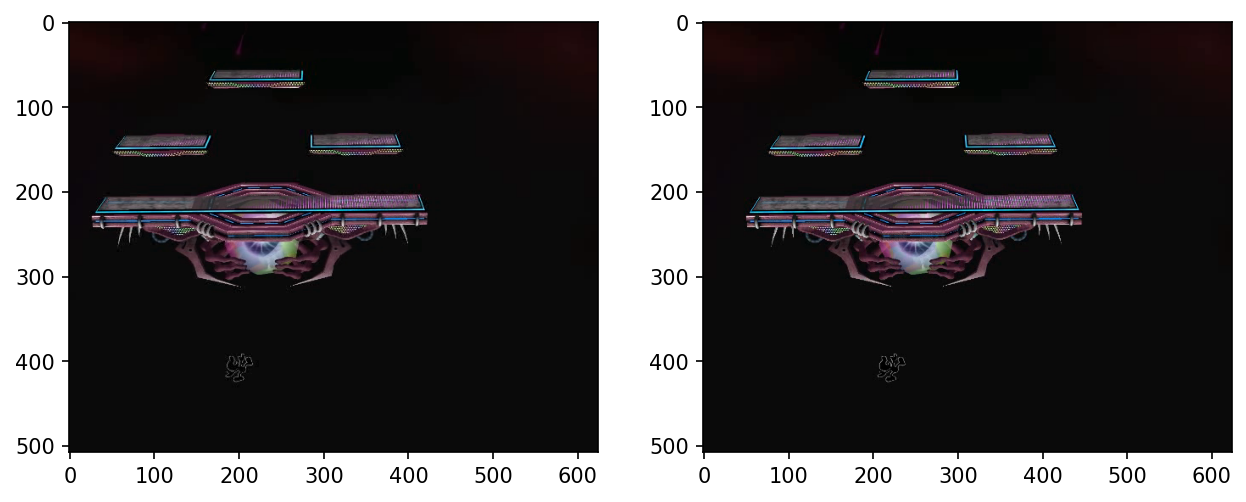

In [281]:
capture = cv.VideoCapture('videos/battlefield_camera.avi')
initial_skip = 3110
gap = 6
capture.set(cv.CAP_PROP_POS_FRAMES, initial_skip)
success, frame2 = capture.read()
capture.set(cv.CAP_PROP_POS_FRAMES, initial_skip + gap)
success, frame1 = capture.read()
H, W = frame1.shape[:2]

ax = plt.subplot(121)
ax.imshow(frame1)
ax = plt.subplot(122)
ax.imshow(frame2)
plt.show()

In [282]:
def compare_palettes(p1, p2):
    # normalize palettes' values during comparison
    p1_tot = sum(p1.values())
    p2_tot = sum(p2.values())
    
    shared = 0
    for color in p1.keys():
        if color in p2:
            shared += min(p1[color] / p1_tot, 
                          p2[color] / p2_tot)
    return shared

In [283]:
def color_descriptors(kps, img):
    patch_radius = 24
    
    img = bg.reduce(img)
    
    H, W = img.shape[:2]
    palettes = []
    for kp in kps:
        x, y = kp.pt
        x, y = int(round(x)), int(round(y))
        # shrinks if edgy
        curr_patch_radius = bg.validate_if_edge(x, y, W, H, patch_radius)
        # extract patch
        x0 = x-curr_patch_radius
        x1 = x+curr_patch_radius
        y0 = y-curr_patch_radius
        y1 = y+curr_patch_radius
        patch = img[y0:y1,
                    x0:x1]
        
        palette = {}
        for row in patch:
            for px in row:
                px = tuple(px)
                if px not in palette:
                    palette[px] = 1
                else:
                    palette[px] += 1
        palettes.append(palette)
    return palettes


In [284]:
# kps = bg.custom_keypoints(frame1)
# color_descs = color_descriptors(kps, frame1)

# for palette in color_descs:
#     # should sort seen by color for pie chart
#     colors = [(r/255, g/255, b/255) for (r,g,b) in palette.keys()]
#     plt.pie(palette.values(), colors=colors)
#     plt.show()

In [285]:
p1 = np.random.choice(palettes)
p2 = np.random.choice(palettes)
comparison = compare_palettes(p1, p2)
print(p1)
print(p2)
comparison

{(0, 0, 0): 627, (64, 0, 0): 197, (64, 0, 64): 247, (64, 64, 64): 468, (128, 64, 64): 207, (64, 64, 0): 5, (0, 0, 64): 63, (0, 64, 64): 13, (0, 64, 128): 27, (0, 128, 192): 226, (0, 64, 0): 2, (0, 64, 192): 10, (64, 128, 128): 7, (128, 128, 128): 33, (64, 64, 128): 2, (128, 64, 128): 21, (192, 128, 128): 45, (192, 128, 192): 21, (192, 192, 192): 83}
{(0, 0, 0): 984, (0, 0, 64): 32, (0, 128, 128): 40, (0, 128, 192): 166, (0, 192, 192): 61, (0, 64, 64): 7, (0, 64, 128): 31, (64, 64, 64): 263, (64, 128, 128): 4, (64, 0, 0): 231, (64, 0, 64): 161, (64, 192, 192): 9, (128, 64, 64): 221, (128, 64, 128): 27, (128, 128, 128): 23, (192, 192, 192): 30, (64, 64, 0): 5, (64, 128, 192): 4, (0, 64, 192): 2, (0, 64, 0): 2, (64, 128, 64): 1}


0.7699652777777777

In [286]:
kps1 = bg.custom_keypoints(frame1)
des1 = color_descriptors(kps1, frame1)
kps2 = bg.custom_keypoints(frame2)
des2 = color_descriptors(kps2, frame2)

In [287]:
matches_result = []    # des2 matches for des1
for i in range(len(des1)):
    d1 = des1[i]
    scores = []
    for j in range(len(des2)):
        d2 = des2[j]
        score = compare_palettes(d1, d2)
        k = 0
        while k < len(scores):
            if score > scores[k][1]:
                break
            k += 1
        scores.insert(k, (j, score))
    matches_result.append(scores)

In [288]:
def rnd_color():
    return [np.random.random() * 255 for _ in range(3)]

def slope(dy, dx):
    return dy / dx if not dx == 0 else 1000    # arbitrary big represent vertical slope

In [289]:
def best_match(kp1, matches_with_scores, kps2):
    x0, y0 = kp1.pt
    
    for match_index, score in matches_with_scores:
        kp2 = kps2[match_index]
        x1, y1 = kp2.pt
        dy = (y1 - y0)
        dx = (x1 - x0)
        m = slope(dy, dx)

        qualifies = abs(dx) < 100 and abs(dy) < 100 and score > 0.5
        
        if qualifies:
            return kp2, x0, y0, x1, y1, dy, dx, m, score
        else:
            print('bad match; checking next match')
    return None
    

0.99 23.0 0.0 0.0
0.97 -70.0 0.0 -0.0
0.99 22.0 0.0 0.0
0.98 20.0 0.0 0.0
0.98 24.0 0.0 0.0
0.95 19.0 5.0 0.2631578947368421
0.93 28.0 1.0 0.03571428571428571
0.87 44.0 0.0 0.0
0.95 16.0 2.0 0.125
0.91 19.0 -21.0 -1.105263157894737
0.94 25.0 3.0 0.12
0.87 33.0 19.0 0.5757575757575758
0.92 -25.0 25.0 -1.0
0.94 -5.0 24.0 -4.8
0.81 27.0 21.0 0.7777777777777778
0.95 30.0 4.0 0.13333333333333333
bad match; checking next match
0.93 30.0 -3.0 -0.1
0.94 44.0 -5.0 -0.11363636363636363
bad match; checking next match
0.9 1.0 -8.0 -8.0
0.91 -1.0 -1.0 1.0
bad match; checking next match
bad match; checking next match
bad match; checking next match
0.89 -37.0 -39.0 1.054054054054054
0.95 11.0 -4.0 -0.36363636363636365
0.98 22.0 0.0 0.0
0.94 30.0 1.0 0.03333333333333333
0.94 24.0 5.0 0.20833333333333334
0.99 27.0 0.0 0.0
0.86 9.0 -20.0 -2.2222222222222223
0.9 14.0 9.0 0.6428571428571429
bad match; checking next match
bad match; checking next match
bad match; checking next match
bad match; checking nex

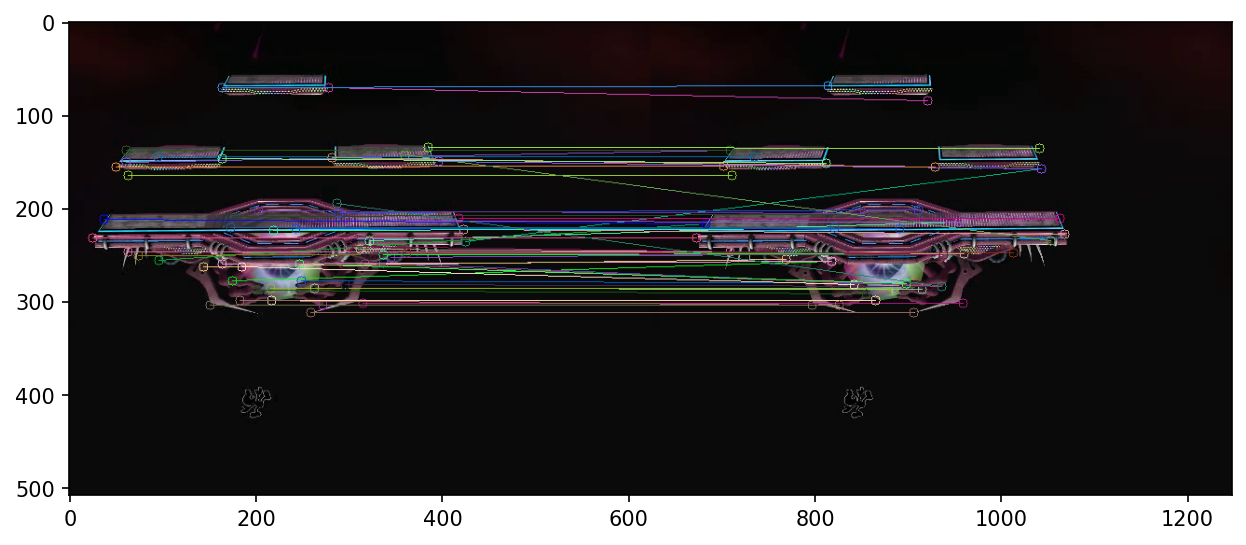

In [290]:
scores = []
xdiffs = []
ydiffs = []
valid_pairs = []
combined = np.hstack((frame1, frame2))
for i, matches_with_scores in enumerate(matches_result):
    kp1 = kps1[i]
    x0, y0 = kp1.pt
    
    result = best_match(kp1, matches_with_scores, kps2)
    if not result:
        continue
        
    kp2, x0, y0, x1, y1, dy, dx, m, score = result
    print(round(score, 2), dx, dy, m)
    
    valid_pairs.append((kp1, kp2))
    
    scores.append(score)
    ydiffs.append(dy)
    xdiffs.append(dx)

    pt1 = (int(x0), int(y0))
    pt2 = (int(x1) + W, int(y1))
    color = rnd_color()
    combined = cv.circle(combined, pt1, 5, color)
    combined = cv.circle(combined, pt2, 5, color)
    combined = cv.line(combined, pt1, pt2, color, 1)

plt.imshow(combined)
plt.show()

In [291]:
len(valid_pairs), len(matches_result)

(53, 53)

In [292]:
sum(xdiffs) / len(xdiffs), sum(ydiffs) / len(ydiffs), slope(sum(ydiffs), sum(xdiffs))

(19.18867924528302, 2.830188679245283, 0.14749262536873156)

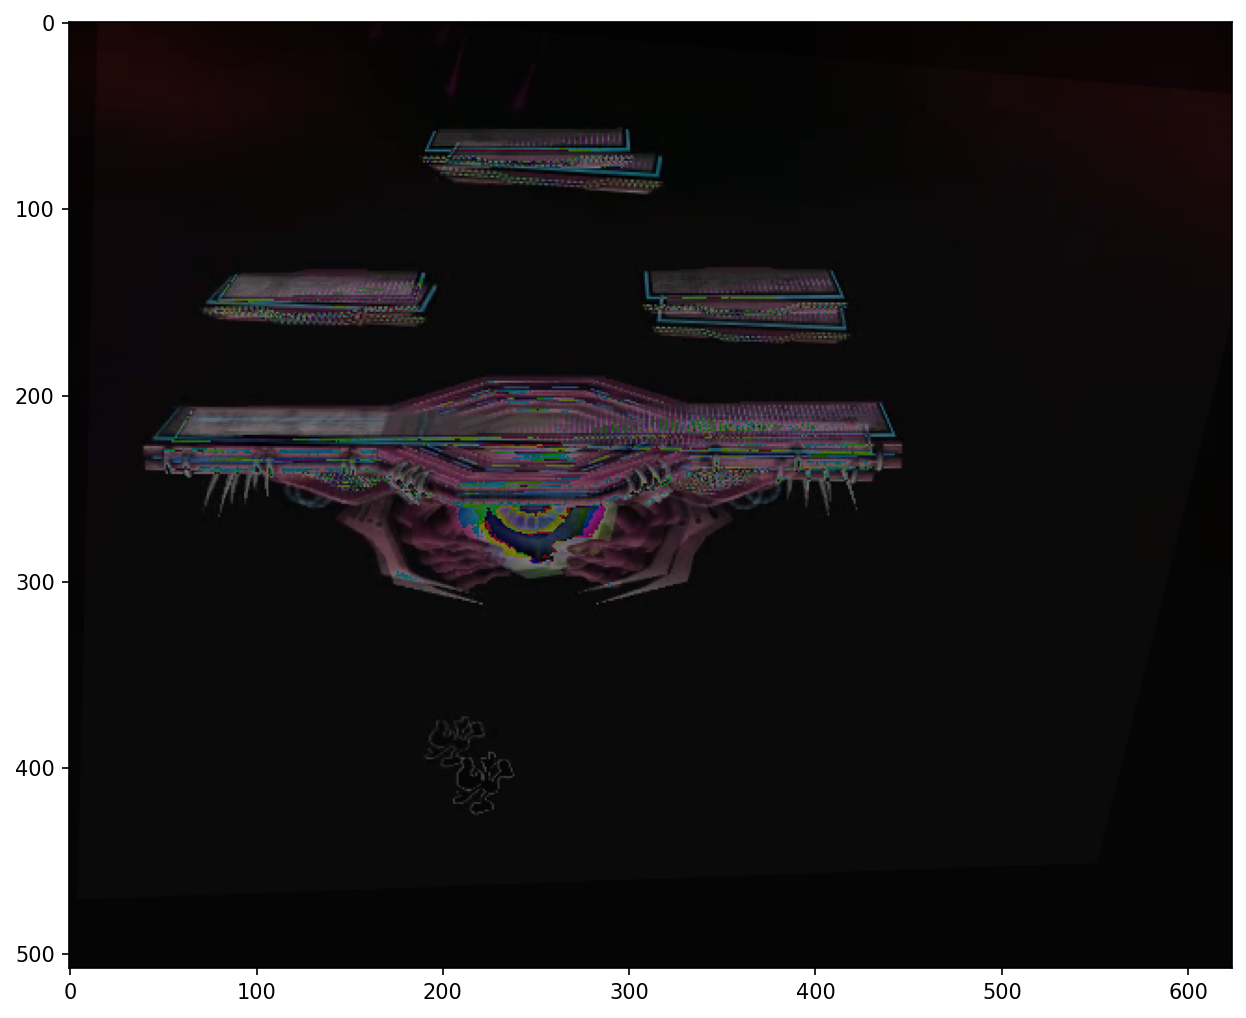

In [293]:
pts1 = np.array([kp1.pt for (kp1, kp2) in valid_pairs])
pts2 = np.array([kp2.pt for (kp1, kp2) in valid_pairs])

h, status = cv.findHomography(pts1, pts2)

warped = cv.warpPerspective(frame1, h, (W, H))

averaged = (warped + frame2) * 0.5
averaged = averaged.astype(np.uint8)

plt.imshow(averaged)
plt.show()